In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CIFAR10, Flowers102
from torchgeo.datasets import UCMerced
from torchvision.models import alexnet
import torch.nn.functional as F
from tqdm import tqdm

from easyfsl.samplers import TaskSampler
from easyfsl.datasets import WrapFewShotDataset

from AlexNetLastTwoLayers import AlexNetLastTwoLayers
from PrototypicalNetworks import PrototypicalNetworks
from PrototypicalFlagNetworks import PrototypicalFlagNetworks
from PIL import Image



import copy

from statistics import mean

from matplotlib import pyplot as plt

import pandas as pd

import random

In [2]:
def evaluate(model_, val_loader, DEVICE):
    model_.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():  # No gradients needed during validation
        for val_support_images, val_support_labels, val_query_images, val_query_labels, _ in val_loader:
            # Obtain validation predictions
            val_preds = model_(val_support_images.to(DEVICE), val_support_labels.to(DEVICE), val_query_images.to(DEVICE))
            
            # Count correct predictions
            correct += (val_preds.argmax(dim=2).reshape(-1) == val_query_labels.to(DEVICE)).sum().item()
            total += val_query_labels.size(0)
            

    # Calculate validation accuracy
    val_accuracy = correct / total
    return val_accuracy

In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
random_seed = 0

random.seed(random_seed)
torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
N_WAY = 5  # Number of classes in a task
N_QUERY = 10  # Number of images per class in the query set
N_EVALUATION_TASKS = 100

transform = transforms.Compose(
        [
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize(mean = (0.485, 0.456, 0.406), std = (0.229, 0.224, 0.225))
        ]
)

test_data = WrapFewShotDataset(
    CIFAR10(
    root="../data",
    transform=transform,
    download=True,
    train = False )  
)

# test_data = WrapFewShotDataset(
#     Flowers102(
#     root="../data",
#     transform=transform,
#     download=True,
#     split = 'test')
# )




Files already downloaded and verified


Scrolling dataset's labels...: 100%|██████████| 10000/10000 [00:06<00:00, 1525.67it/s]


In [6]:
#takes about 2hr with one GPU
results = pd.DataFrame(columns = ['Method', 'N Shots', 'Accuracy'])

alexnet_backbone = alexnet(pretrained = True)
alexnet_backbone.classifier[6] = nn.Flatten()

alexnet_backbone1 = alexnet(pretrained = True)
alexnet_backbone1 = AlexNetLastTwoLayers(alexnet_backbone1).to(DEVICE)



for N_SHOT in [3,5,7]:
    print(f'Starting {N_SHOT}')
    test_sampler = TaskSampler(
            test_data, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS
        )

    test_loader = DataLoader(
        test_data,
        batch_sampler=test_sampler,
        num_workers=0,
        pin_memory=True,
        collate_fn=test_sampler.episodic_collate_fn,
        shuffle = False
    )

    for random_seed in tqdm(range(20)):

        # # Eval Protonets
        random.seed(random_seed)
        proto_model = PrototypicalNetworks(alexnet_backbone, head = 'ProtoNet').to(DEVICE)
        proto_acc = evaluate(proto_model, test_loader, DEVICE)
        row = pd.DataFrame(columns = results.columns,
                           data = [['ProtoNets', N_SHOT, proto_acc]])
        results = pd.concat([results, row])

        # # Eval Subspace Nets
        random.seed(random_seed)
        subspace_model = PrototypicalNetworks(alexnet_backbone, head = 'SubspaceNet').to(DEVICE)
        subspace_acc = evaluate(subspace_model, test_loader, DEVICE)
        row = pd.DataFrame(columns = results.columns,
                           data = [['SubspaceNets', N_SHOT, subspace_acc]])
        results = pd.concat([results, row])

        # Eval Flag Nets
        random.seed(random_seed)
        flag_model = PrototypicalFlagNetworks(alexnet_backbone1).to(DEVICE)
        flag_acc = evaluate(flag_model, test_loader, DEVICE)
        row = pd.DataFrame(columns = results.columns,
                           data = [['FlagNets', N_SHOT, flag_acc]])
        results = pd.concat([results, row])

    results.to_csv('../results/cifar10_probing1.csv')

/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nate/anaconda3/envs/flags3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting 3


  0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipykernel_132495/1598796197.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, row])
100%|██████████| 20/20 [16:40<00:00, 50.04s/it]


Starting 5


100%|██████████| 20/20 [17:11<00:00, 51.56s/it]


Starting 7


100%|██████████| 20/20 [18:30<00:00, 55.51s/it]


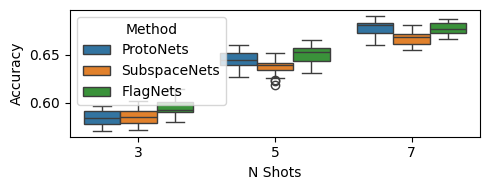

In [7]:
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt

res = pd.read_csv('../results/cifar10_probing1.csv')

plt.figure(figsize = (5,2))
sns.boxplot(res, x = 'N Shots', y = 'Accuracy', hue = 'Method')
plt.tight_layout()
plt.savefig('../results/cifar10_probing1.pdf', bbox_inches = "tight")